# Machine Learning to Identify Fraud in the Enron Corpus

In [1]:
import warnings 
warnings.filterwarnings("ignore")
import sys
import pickle
sys.path.append("../tools/")
from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data
import pandas as pd
import sys
import pickle
import csv
import matplotlib.pyplot as plt

sys.path.append("../tools/")
from feature_format import featureFormat, targetFeatureSplit
#from poi_data import *
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit

from numpy import mean
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate

from sklearn.metrics import accuracy_score, precision_score, recall_score

## Task 1: Select what features you'll use

features_list is a list of strings, each of which is a feature name.    
The first feature must be "poi".    
features_list = ['poi','salary']    
**You will need to use more features**

In [2]:
target_label = 'poi'

email_features_list = [
    'from_messages',
    'from_poi_to_this_person',
    'from_this_person_to_poi',
    'shared_receipt_with_poi',
    'to_messages',
    ]
    
financial_features_list = [
    'bonus',
    'deferral_payments',
    'deferred_income',
    'director_fees',
    'exercised_stock_options',
    'expenses',
    'loan_advances',
    'long_term_incentive',
    'other',
    'restricted_stock',
    'restricted_stock_deferred',
    'salary',
    'total_payments',
    'total_stock_value',
]

features_list = [target_label] + financial_features_list + email_features_list

In [3]:
### Load the dictionary containing the dataset

with open('final_project_dataset.pkl', 'rb') as data_file:
    data_dict = pickle.load(data_file)

In [4]:
df = pd.DataFrame(data_dict)
#df['LOCKHART EUGENE E']
df.T

,salary,to_messages,deferral_payments,total_payments,loan_advances,bonus,email_address,restricted_stock_deferred,deferred_income,total_stock_value,...,from_poi_to_this_person,exercised_stock_options,from_messages,other,from_this_person_to_poi,poi,long_term_incentive,shared_receipt_with_poi,restricted_stock,director_fees
METTS MARK,365788,807,NaN,1061827,NaN,600000,mark.metts@enron.com,NaN,NaN,585062,...,38,NaN,29,1740,1,False,NaN,702,585062,NaN
BAXTER JOHN C,267102,NaN,1295738,5634343,NaN,1200000,NaN,NaN,-1386055,10623258,...,NaN,6680544,NaN,2660303,NaN,False,1586055,NaN,3942714,NaN
ELLIOTT STEVEN,170941,NaN,NaN,211725,NaN,350000,steven.elliott@enron.com,NaN,-400729,6678735,...,NaN,4890344,NaN,12961,NaN,False,NaN,NaN,1788391,NaN
CORDES WILLIAM R,NaN,764,NaN,NaN,NaN,NaN,bill.cordes@enron.com,NaN,NaN,1038185,...,10,651850,12,NaN,0,False,NaN,58,386335,NaN
HANNON KEVIN P,243293,1045,NaN,288682,NaN,1500000,kevin.hannon@enron.com,NaN,-3117011,6391065,...,32,5538001,32,11350,21,True,1617011,1035,853064,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GRAMM WENDY L,NaN,NaN,NaN,119292,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,119292
CAUSEY RICHARD A,415189,1892,NaN,1868758,NaN,1000000,richard.causey@enron.com,NaN,-235000,2502063,...,58,NaN,49,307895,12,True,350000,1585,2502063,NaN
TAYLOR MITCHELL S,265214,533,227449,1092663,NaN,600000,mitchell.taylor@enron.com,NaN,NaN,3745048,...,0,3181250,29,NaN,0,False,NaN,300,563798,NaN
DONAHUE JR JEFFREY M,278601,865,NaN,875760,NaN,800000,jeff.donahue@enron.com,NaN,-300000,1080988,...,188,765920,22,891,11,False,NaN,772,315068,NaN


In [5]:
df.T.describe()

,salary,to_messages,deferral_payments,total_payments,loan_advances,bonus,email_address,restricted_stock_deferred,deferred_income,total_stock_value,...,from_poi_to_this_person,exercised_stock_options,from_messages,other,from_this_person_to_poi,poi,long_term_incentive,shared_receipt_with_poi,restricted_stock,director_fees
count,146,146,146,146,146,146,146,146,146,146,...,146,146,146,146,146,146,146,146,146,146
unique,95,87,40,126,5,42,112,19,45,125,...,58,102,65,93,42,2,53,84,98,18
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN
freq,51,60,107,21,142,64,35,128,97,20,...,60,44,60,53,60,128,80,60,36,129


### 1.1.0 Explore csv file 

In [6]:
def make_csv(data_dict):
    """ generates a csv file from a data set"""
    fieldnames = ['name'] + data_dict.itervalues().next().keys()
    with open('data.csv', 'w') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        for record in data_dict:
            person = data_dict[record]
            person['name'] = record
            assert set(person.keys()) == set(fieldnames)
            writer.writerow(person)

### 1.1.1 Dataset Exploration

In [7]:
print('# Exploratory Data Analysis #')
data_dict.keys()
print('Total number of data points: %d' % len(data_dict.keys()))
num_poi = 0
for name in data_dict.keys():
    if data_dict[name]['poi'] == True:
        num_poi += 1
print('Number of Persons of Interest: %d' % num_poi)
print('Number of people without Person of Interest label: %d' % (len(data_dict.keys()) - num_poi))

# Exploratory Data Analysis #
Total number of data points: 146
Number of Persons of Interest: 18
Number of people without Person of Interest label: 128


### 1.1.2 Feature Exploration

In [8]:
all_features = data_dict['ALLEN PHILLIP K'].keys()
print('Each person has %d features available' %  len(all_features))
### Evaluate dataset for completeness
missing_values = {}
for feature in all_features:
    missing_values[feature] = 0
for person in data_dict.keys():
    records = 0
    for feature in all_features:
        if data_dict[person][feature] == 'NaN':
            missing_values[feature] += 1
        else:
            records += 1

Each person has 21 features available


### Print results of completeness analysis

In [9]:
print('Number of Missing Values for Each Feature:')

#sorted(missing_values.values())

#for feature in all_features:
   # print("%s: %d" % (feature, sorted(missing_values.values())[feature])


for id in sorted(missing_values, key = missing_values.get, reverse = True):
          print(id, missing_values[id])


Number of Missing Values for Each Feature:
loan_advances 142
director_fees 129
restricted_stock_deferred 128
deferral_payments 107
deferred_income 97
long_term_incentive 80
bonus 64
to_messages 60
from_poi_to_this_person 60
from_messages 60
from_this_person_to_poi 60
shared_receipt_with_poi 60
other 53
salary 51
expenses 51
exercised_stock_options 44
restricted_stock 36
email_address 35
total_payments 21
total_stock_value 20
poi 0


### Impute NA

In [10]:
from sklearn.impute import SimpleImputer

In [11]:
from sklearn.model_selection import GridSearchCV, train_test_split

In [12]:
from sklearn.pipeline import make_pipeline

In [13]:
from sklearn.impute import KNNImputer

In [14]:
from sklearn.ensemble import RandomForestClassifier


In [15]:
x=df.T[['salary', 'to_messages', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus', 
            'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses', 'from_poi_to_this_person', 
           'exercised_stock_options', 'from_messages', 'other', 'from_this_person_to_poi', 'long_term_incentive', 
            'shared_receipt_with_poi', 'restricted_stock', 'director_fees']].to_numpy()

In [16]:
y=df.T[["poi"]]

In [17]:
y=pd.get_dummies(y)

In [18]:
y['poi_True']

METTS MARK              0
BAXTER JOHN C           0
ELLIOTT STEVEN          0
CORDES WILLIAM R        0
HANNON KEVIN P          1
                       ..
GRAMM WENDY L           0
CAUSEY RICHARD A        1
TAYLOR MITCHELL S       0
DONAHUE JR JEFFREY M    0
GLISAN JR BEN F         1
Name: poi_True, Length: 146, dtype: uint8

In [19]:
y=y['poi_True'].to_numpy()

In [20]:
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=0)

#### Simple Imputer

In [21]:
model1=make_pipeline(SimpleImputer(),RandomForestClassifier())
params1 = {'simpleimputer__strategy': ["mean","median","constant"]}
grid = GridSearchCV(model1, param_grid=params1,cv=10, scoring="precision")
grid.fit(X_train, y_train)
grid.best_score_

0.3

In [22]:
grid.best_estimator_


Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('randomforestclassifier', RandomForestClassifier())])

#### KNN Imputer

In [23]:
grid.best_estimator_

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('randomforestclassifier', RandomForestClassifier())])

In [24]:
model = make_pipeline(KNNImputer(),RandomForestClassifier())
params = {'knnimputer__n_neighbors' : [1, 2, 3, 4, 5, 6, 7, 8, 9,10]}
grid = GridSearchCV(model, param_grid=params,cv=10, scoring="precision")

grid.fit(X_train, y_train)
grid.best_score_

0.25

In [25]:
grid.cv_results_

{'mean_fit_time': array([0.14400373, 0.12676537, 0.15305376, 0.14256613, 0.12390769,
        0.13118653, 0.14202447, 0.14530692, 0.12879121, 0.13675358]),
 'std_fit_time': array([0.01587662, 0.00584866, 0.01325063, 0.01459549, 0.00468568,
        0.00527295, 0.01243206, 0.01711557, 0.01195805, 0.0098808 ]),
 'mean_score_time': array([0.01632242, 0.01423321, 0.01686535, 0.01622648, 0.01467221,
        0.01438899, 0.01585834, 0.01574512, 0.01389172, 0.01575861]),
 'std_score_time': array([0.00155762, 0.00147676, 0.00178224, 0.00219775, 0.00132362,
        0.00110601, 0.00275838, 0.00180531, 0.00084072, 0.00215367]),
 'param_knnimputer__n_neighbors': masked_array(data=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'params': [{'knnimputer__n_neighbors': 1},
  {'knnimputer__n_neighbors': 2},
  {'knnimputer__n_neighbors': 3},
  {'knnimputer__n_

Best imputer : Knn. Let's apply fit tranform and see change 

In [26]:
imputer = KNNImputer(n_neighbors=4)

In [27]:
df_T = df.T[['salary', 'to_messages', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus', 
            'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses', 'from_poi_to_this_person', 
           'exercised_stock_options', 'from_messages', 'other', 'from_this_person_to_poi', 'long_term_incentive', 
            'shared_receipt_with_poi', 'restricted_stock', 'director_fees']]

imputer = KNNImputer(n_neighbors=4)

df_T_n=imputer.fit_transform(df_T.to_numpy())

In [28]:
new_dataset=pd.DataFrame(data=df_T_n, index=data_dict.keys(),columns=['salary', 'to_messages', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus', 
            'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses', 'from_poi_to_this_person', 
           'exercised_stock_options', 'from_messages', 'other', 'from_this_person_to_poi', 'long_term_incentive', 
            'shared_receipt_with_poi', 'restricted_stock', 'director_fees'])

In [29]:
new_dataset

,salary,to_messages,deferral_payments,total_payments,loan_advances,bonus,restricted_stock_deferred,deferred_income,total_stock_value,expenses,from_poi_to_this_person,exercised_stock_options,from_messages,other,from_this_person_to_poi,long_term_incentive,shared_receipt_with_poi,restricted_stock,director_fees
METTS MARK,365788.00,807.00,265650.50,1061827.0,41962500.0,600000.0,-320994.75,-64687.5,585062.0,94299.00,38.00,490148.25,29.00,1740.00,1.0,211868.50,702.0,585062.00,65562.00
BAXTER JOHN C,267102.00,2241.00,1295738.00,5634343.0,41962500.0,1200000.0,-671840.75,-1386055.0,10623258.0,11200.00,65.50,6680544.00,377.25,2660303.00,11.0,1586055.00,1343.5,3942714.00,65382.25
ELLIOTT STEVEN,170941.00,606.50,823349.00,211725.0,41962500.0,350000.0,-260061.75,-400729.0,6678735.0,78552.00,8.75,4890344.00,24.75,12961.00,1.0,279303.00,232.0,1788391.00,110906.00
CORDES WILLIAM R,260119.25,764.00,1819950.75,639309.5,41962500.0,452187.5,-269785.00,-150573.0,1038185.0,67085.25,10.00,651850.00,12.00,13948.50,0.0,740019.50,58.0,386335.00,84381.50
HANNON KEVIN P,243293.00,1045.00,867370.00,288682.0,41962500.0,1500000.0,-698791.75,-3117011.0,6391065.0,34039.00,32.00,5538001.00,32.00,11350.00,21.0,1617011.00,1035.0,853064.00,89968.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GRAMM WENDY L,144826.00,966.75,106154.75,119292.0,41962500.0,505000.0,-43181.00,-43446.0,9875254.0,31966.25,54.25,9779932.75,75.25,51394.00,12.5,546024.25,459.5,561557.25,119292.00
CAUSEY RICHARD A,415189.00,1892.00,910104.25,1868758.0,41962500.0,1000000.0,-398036.25,-235000.0,2502063.0,30674.00,58.00,1698947.50,49.00,307895.00,12.0,350000.00,1585.0,2502063.00,65998.75
TAYLOR MITCHELL S,265214.00,533.00,227449.00,1092663.0,41962500.0,600000.0,-260061.75,-242734.5,3745048.0,47075.25,0.00,3181250.00,29.00,171194.25,0.0,346371.75,300.0,563798.00,65562.00
DONAHUE JR JEFFREY M,278601.00,865.00,477365.75,875760.0,41962500.0,800000.0,-208024.25,-300000.0,1080988.0,96268.00,188.00,765920.00,22.00,891.00,11.0,193573.50,772.0,315068.00,65562.00


In [30]:
len(df.T[["poi"]])

146

In [31]:
new_dataset["poi"]=df.T[["poi"]]

In [32]:
new_dataset

,salary,to_messages,deferral_payments,total_payments,loan_advances,bonus,restricted_stock_deferred,deferred_income,total_stock_value,expenses,from_poi_to_this_person,exercised_stock_options,from_messages,other,from_this_person_to_poi,long_term_incentive,shared_receipt_with_poi,restricted_stock,director_fees,poi
METTS MARK,365788.00,807.00,265650.50,1061827.0,41962500.0,600000.0,-320994.75,-64687.5,585062.0,94299.00,38.00,490148.25,29.00,1740.00,1.0,211868.50,702.0,585062.00,65562.00,False
BAXTER JOHN C,267102.00,2241.00,1295738.00,5634343.0,41962500.0,1200000.0,-671840.75,-1386055.0,10623258.0,11200.00,65.50,6680544.00,377.25,2660303.00,11.0,1586055.00,1343.5,3942714.00,65382.25,False
ELLIOTT STEVEN,170941.00,606.50,823349.00,211725.0,41962500.0,350000.0,-260061.75,-400729.0,6678735.0,78552.00,8.75,4890344.00,24.75,12961.00,1.0,279303.00,232.0,1788391.00,110906.00,False
CORDES WILLIAM R,260119.25,764.00,1819950.75,639309.5,41962500.0,452187.5,-269785.00,-150573.0,1038185.0,67085.25,10.00,651850.00,12.00,13948.50,0.0,740019.50,58.0,386335.00,84381.50,False
HANNON KEVIN P,243293.00,1045.00,867370.00,288682.0,41962500.0,1500000.0,-698791.75,-3117011.0,6391065.0,34039.00,32.00,5538001.00,32.00,11350.00,21.0,1617011.00,1035.0,853064.00,89968.50,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GRAMM WENDY L,144826.00,966.75,106154.75,119292.0,41962500.0,505000.0,-43181.00,-43446.0,9875254.0,31966.25,54.25,9779932.75,75.25,51394.00,12.5,546024.25,459.5,561557.25,119292.00,False
CAUSEY RICHARD A,415189.00,1892.00,910104.25,1868758.0,41962500.0,1000000.0,-398036.25,-235000.0,2502063.0,30674.00,58.00,1698947.50,49.00,307895.00,12.0,350000.00,1585.0,2502063.00,65998.75,True
TAYLOR MITCHELL S,265214.00,533.00,227449.00,1092663.0,41962500.0,600000.0,-260061.75,-242734.5,3745048.0,47075.25,0.00,3181250.00,29.00,171194.25,0.0,346371.75,300.0,563798.00,65562.00,False
DONAHUE JR JEFFREY M,278601.00,865.00,477365.75,875760.0,41962500.0,800000.0,-208024.25,-300000.0,1080988.0,96268.00,188.00,765920.00,22.00,891.00,11.0,193573.50,772.0,315068.00,65562.00,False


In [33]:
data_dict=new_dataset.to_dict(orient='index')

## Task 2: Remove outliers

In [34]:
def PlotOutlier(data_dict, feature_x, feature_y):
    """ Plot with flag = True in Red """
    data = featureFormat(data_dict, [feature_x, feature_y, 'poi'])
    for point in data:
        x = point[0]
        y = point[1]
        poi = point[2]
        if poi:
            color = 'red'
        else:
            color = 'blue'
        plt.scatter(x, y, color=color)
    plt.xlabel(feature_x)
    plt.ylabel(feature_y)
    plt.show()

### 2.1 Visualise outliers

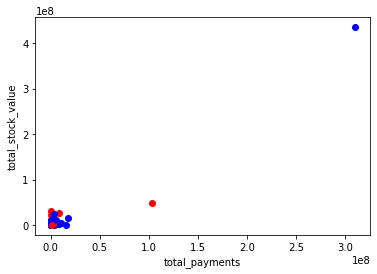

None


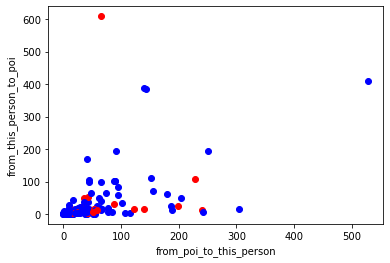

None


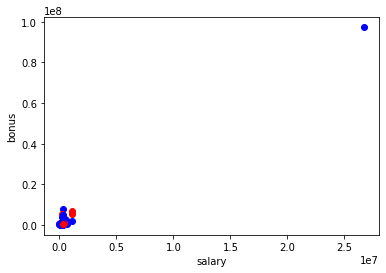

None


{'salary': 26704229.0,
 'to_messages': 1353.5,
 'deferral_payments': 32083396.0,
 'total_payments': 309886585.0,
 'loan_advances': 83925000.0,
 'bonus': 97343619.0,
 'restricted_stock_deferred': -7576788.0,
 'deferred_income': -27992891.0,
 'total_stock_value': 434509511.0,
 'expenses': 5235198.0,
 'from_poi_to_this_person': 40.5,
 'exercised_stock_options': 311764000.0,
 'from_messages': 22.75,
 'other': 42667589.0,
 'from_this_person_to_poi': 6.5,
 'long_term_incentive': 48521928.0,
 'shared_receipt_with_poi': 683.25,
 'restricted_stock': 130322299.0,
 'director_fees': 1398517.0,
 'poi': False}

In [35]:
print(PlotOutlier(data_dict, 'total_payments', 'total_stock_value'))
print(PlotOutlier(data_dict, 'from_poi_to_this_person', 'from_this_person_to_poi'))
print(PlotOutlier(data_dict, 'salary', 'bonus'))
#Remove outlier TOTAL line in pickle file.
data_dict.pop( 'TOTAL', 0 )

### 2.2 Function to remove outliers

In [36]:
def remove_outlier(dict_object, keys):
    """ removes list of outliers keys from dict object """
    for key in keys:
        dict_object.pop(key, 0)

outliers = ['TOTAL', 'THE TRAVEL AGENCY IN THE PARK', 'LOCKHART EUGENE E']
remove_outlier(data_dict, outliers)

=>Remove columns   
Maybe more outliers ? 

### Task 3: Create new feature(s)

### 3.1 create new copies of dataset for grading

In [37]:
my_dataset = data_dict

### 3.2 add new features to dataset

In [38]:
def compute_fraction(poi_messages, all_messages):
    """ return fraction of messages from/to that person to/from POI"""    
    if poi_messages == 'NaN' or all_messages == 'NaN':
        return 0.
    fraction = poi_messages / all_messages
    return fraction

In [39]:
for name in my_dataset:
    data_point = my_dataset[name]
    from_poi_to_this_person = data_point["from_poi_to_this_person"]
    to_messages = data_point["to_messages"]
    fraction_from_poi = compute_fraction(from_poi_to_this_person, to_messages)
    data_point["fraction_from_poi"] = fraction_from_poi
    from_this_person_to_poi = data_point["from_this_person_to_poi"]
    from_messages = data_point["from_messages"]
    fraction_to_poi = compute_fraction(from_this_person_to_poi, from_messages)
    data_point["fraction_to_poi"] = fraction_to_poi

=> Maybe new features ? 

### 3.3 create new copies of feature list for grading

In [40]:
my_feature_list = features_list +['to_messages', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi','shared_receipt_with_poi', 'fraction_to_poi']

## Feature selection

### 3.4 get K-best features

In [41]:
num_features = 15

### 3.5 function using SelectKBest

In [42]:
def get_k_best(data_dict, features_list, k):
    """ runs scikit-learn's SelectKBest feature selection
        returns dict where keys=features, values=scores
    """
    data = featureFormat(data_dict, features_list)
    labels, features = targetFeatureSplit(data)

    k_best = SelectKBest(k=k)
    k_best.fit(features, labels)
    scores = k_best.scores_
    print(scores)
    unsorted_pairs = zip(features_list[1:], scores)
    sorted_pairs = list(reversed(sorted(unsorted_pairs, key=lambda x: x[1])))
    k_best_features = dict(sorted_pairs[:k])
    print ("{0} best features: {1}\n".format(k, k_best_features.keys(), scores))
    return k_best_features

Recursive feature Elimination

In [43]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression

def get_recursive_best(data_dict, features_list, k):
    """ runs scikit-learn's SelectKBest feature selection
        returns dict where keys=features, values=scores
    """
    data = featureFormat(data_dict, features_list)
    labels, features = targetFeatureSplit(data)

    rec_best = RFECV(LogisticRegression(random_state=0), step=1, min_features_to_select=k, cv=20)
    rec_best.fit(features, labels)
    scores = rec_best.grid_scores_
    print(scores)
    unsorted_pairs = zip(features_list[1:], scores)
    sorted_pairs = list(reversed(sorted(unsorted_pairs, key=lambda x: x[1])))
    rec_best_features = dict(sorted_pairs[:k])
    print ("{0} best features: {1}\n".format(k, rec_best_features.keys(), scores))
    return rec_best_features


best_features_rec = get_recursive_best(my_dataset, my_feature_list, num_features)
my_rec_feature_list = [target_label] + list(set(best_features_rec.keys()))


In [44]:
best_features = get_k_best(my_dataset, my_feature_list, num_features)

my_feature_list = [target_label] + list(set(best_features.keys()))


[13.09194988  1.61965191 10.5797683   0.47114772 24.97095225  0.86590663
  3.794392    8.93002341  3.67201071 11.22424804  0.13828023 11.07517735
  8.4669241  22.43775097  0.47816352  3.20830339  1.56416335  7.52919918
  0.59119378  0.59119378  3.20830339  0.47816352  1.56416335  7.52919918
 14.31171478]
15 best features: dict_keys(['exercised_stock_options', 'total_stock_value', 'fraction_to_poi', 'bonus', 'restricted_stock', 'salary', 'deferred_income', 'long_term_incentive', 'total_payments', 'shared_receipt_with_poi', 'loan_advances', 'other', 'from_poi_to_this_person'])



### 3.6 print features

In [45]:
print ("{0} selected features: {1}\n".format(len(my_feature_list) - 1, my_feature_list[1:]))

13 selected features: ['fraction_to_poi', 'deferred_income', 'total_payments', 'shared_receipt_with_poi', 'salary', 'other', 'from_poi_to_this_person', 'long_term_incentive', 'bonus', 'exercised_stock_options', 'total_stock_value', 'loan_advances', 'restricted_stock']



### 3.7 extract the features specified in features_list


In [46]:
data = featureFormat(my_dataset, my_feature_list,sort_keys = True)

In [47]:
data_rec=featureFormat(my_dataset, my_rec_feature_list,sort_keys = True)

NameError: name 'my_rec_feature_list' is not defined

split into labels and features

In [48]:
labels, features = targetFeatureSplit(data)

In [49]:
#labels, features = targetFeatureSplit(data_rec)

### 3.8 scale features

#### via min-max

In [50]:
from sklearn.preprocessing import MinMaxScaler


In [51]:
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()
features = scaler.fit_transform(features)

robust scaler, poly

In [52]:
from sklearn.preprocessing import RobustScaler

In [53]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, labels, random_state=0)

In [54]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

In [55]:
from sklearn.model_selection import GridSearchCV

model = make_pipeline(MinMaxScaler(), PolynomialFeatures(),
                      StandardScaler(),RobustScaler(),
                      SGDClassifier(random_state=0))
params = {
    'polynomialfeatures__degree':[2, 3, 4,5],
    'sgdclassifier__penalty':['l1', 'l2']
}

grid = GridSearchCV(model, param_grid=params, cv=10,scoring="precision")

grid.fit(X_train, y_train)


grid.best_params_

Best scale: poly degree 2 

grid.score(X_test, y_test)

Let's apply

features=PolynomialFeatures(5).fit_transform(features)

## Task 4: Using algorithm

Please name your classifier clf for easy export below.   
Note that if you want to do PCA or other multi-stage operations,    
you'll need to use Pipelines. For more info:    
http://scikit-learn.org/stable/modules/pipeline.html     

Provided to give you a starting point. Try a variety of classifiers.   

### 4.1  Gaussian Naive Bayes Classifier

In [56]:
from sklearn.naive_bayes import GaussianNB
g_clf = GaussianNB()

### 4.2  Logistic Regression Classifier

In [57]:
from sklearn.linear_model import LogisticRegression

In [58]:
from sklearn.preprocessing import RobustScaler

In [59]:
l_clf = Pipeline(steps=[
        ('scaler', RobustScaler()),
        ('classifier', LogisticRegression(C=1e-08, class_weight='balanced', dual=False, fit_intercept=True, intercept_scaling=1, 
max_iter=100, multi_class='ovr', penalty='l2', random_state=42, solver='liblinear', tol=0.001, verbose=0))])

### 4.3  K-means Clustering

In [60]:
from sklearn.cluster import KMeans
k_clf = KMeans(n_clusters=2, tol=0.001)

### 4.4 Support Vector Machine Classifier

In [61]:
from sklearn.svm import SVC
s_clf = SVC(kernel='rbf', C=1000,gamma = 0.0001,random_state = 42, class_weight = 'balanced')

### 4.5 Random Forest


In [62]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(max_depth = 5,max_features = 'sqrt',n_estimators = 10, random_state = 42, class_weight= 'balanced')

### 4.6 Gradient Boosting Classifier

In [63]:
from imblearn.ensemble import BalancedBaggingClassifier

In [64]:
from sklearn.ensemble  import GradientBoostingClassifier
gb_clf = GradientBoostingClassifier(loss='deviance', learning_rate=0.1, n_estimators=100,random_state = 42)

In [65]:
gb_clf_balance = BalancedBaggingClassifier(random_state=0)

### 4.7 Perceptron

In [66]:
from sklearn.linear_model import Perceptron
pe_clf= Perceptron(max_iter=5)


### 4.8 K Nearest Neighbor:

In [67]:
from sklearn.neighbors import KNeighborsClassifier

In [68]:
knn_clf = KNeighborsClassifier(n_neighbors = 3)

### 4.9 SDG

In [69]:
from sklearn.linear_model import SGDClassifier

In [70]:
sdg_clf = SGDClassifier(random_state=0,penalty='l2')

### 4.10 Multi-layer Perceptron

In [71]:
from sklearn.neural_network import MLPClassifier

In [72]:
mlp_clf = MLPClassifier(random_state=1, max_iter=10)

### 4.7 evaluate function


In [73]:
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek

In [74]:
def evaluate_clf1(clf, features, labels, num_iters=1000, test_size=0.3):
    print (clf)
    accuracy = []
    precision = []
    recall = []
    first = True
    for trial in range(num_iters):
        x_train, x_test, y_train, y_test =\
        train_test_split(features, labels, test_size=test_size)
        clf.fit(x_train, y_train)
        predictions = clf.predict(x_test)
        accuracy.append(accuracy_score(y_test, predictions))
        precision.append(precision_score(y_test, predictions))
        recall.append(recall_score(y_test, predictions))
        if trial % 10 == 0:
            if first:
                sys.stdout.write('\nProcessing')
            sys.stdout.write('.')
            sys.stdout.flush()
            first = False
    print ("done.\n")
    print ("precision: {}".format(mean(precision)))
    print ("recall:    {}".format(mean(recall)))
    print ("accuracy:    {}".format(mean(accuracy)))
    return mean(precision), mean(recall), mean(accuracy)

With Smote

In [75]:
def evaluate_clf(clf, features, labels, num_iters=1000, test_size=0.3):
    print (clf)
    accuracy = []
    precision = []
    recall = []
    first = True
    for trial in range(num_iters):
        x_train, x_test, y_train, y_test =\
        train_test_split(features, labels, test_size=test_size)
        smt = SMOTE()
        x_train, y_train= smt.fit_sample(x_train, y_train)
        clf.fit(x_train, y_train)
        predictions = clf.predict(x_test)
        accuracy.append(accuracy_score(y_test, predictions))
        precision.append(precision_score(y_test, predictions))
        recall.append(recall_score(y_test, predictions))
        if trial % 10 == 0:
            if first:
                sys.stdout.write('\nProcessing')
            sys.stdout.write('.')
            sys.stdout.flush()
            first = False
    print ("done.\n")
    print ("precision: {}".format(mean(precision)))
    print ("recall:    {}".format(mean(recall)))
    print ("accuracy:    {}".format(mean(accuracy)))
    return mean(precision), mean(recall), mean(accuracy)

### 4.8 Evaluate all functions

In [76]:
evaluate_clf(sdg_clf, features, labels)

SGDClassifier(random_state=0)

Processing....................................................................................................done.

precision: 0.23935748405363144
recall:    0.5388670634920635
accuracy:    0.6917441860465116


(0.23935748405363144, 0.5388670634920635, 0.6917441860465116)

In [77]:
evaluate_clf(l_clf, features, labels)


Pipeline(steps=[('scaler', RobustScaler()),
                ('classifier',
                 LogisticRegression(C=1e-08, class_weight='balanced',
                                    multi_class='ovr', random_state=42,
                                    solver='liblinear', tol=0.001))])

Processing......................................................................

ValueError: Expected n_neighbors <= n_samples,  but n_samples = 5, n_neighbors = 6

In [78]:
evaluate_clf(g_clf, features, labels)
evaluate_clf(l_clf, features, labels)
evaluate_clf(k_clf, features, labels)
evaluate_clf(s_clf, features, labels)
evaluate_clf(rf_clf, features, labels)
evaluate_clf(gb_clf, features, labels)
evaluate_clf(pe_clf, features, labels)
evaluate_clf(knn_clf, features, labels)
evaluate_clf(sdg_clf, features, labels)
evaluate_clf(mlp_clf, features, labels)

GaussianNB()

Processing....................................................................................................done.

precision: 0.22566669463176253
recall:    0.36255703463203465
accuracy:    0.6404883720930231
Pipeline(steps=[('scaler', RobustScaler()),
                ('classifier',
                 LogisticRegression(C=1e-08, class_weight='balanced',
                                    multi_class='ovr', random_state=42,
                                    solver='liblinear', tol=0.001))])

Processing.............

ValueError: Expected n_neighbors <= n_samples,  but n_samples = 5, n_neighbors = 6

=> Rajouter fonction print best

## Select best

In [79]:
x_train, x_test, y_train, y_test = train_test_split(features, labels, random_state=0)

In [92]:
from imblearn.ensemble import BalancedRandomForestClassifier
evaluate_clf( BalancedRandomForestClassifier(max_depth= None, n_estimators = 10, random_state = 60, max_features = 'auto')
                           ,features,labels)

BalancedRandomForestClassifier(n_estimators=10, random_state=60)

Processing....................................................................................................done.

precision: 0.3271598568098568
recall:    0.3166407287157287
accuracy:    0.8321395348837208


(0.3271598568098568, 0.3166407287157287, 0.8321395348837208)

In [80]:
smt = SMOTETomek()
x_train, y_train= smt.fit_sample(x_train, y_train)

In [81]:
from sklearn.model_selection import StratifiedShuffleSplit

In [82]:
from sklearn.metrics import f1_score

In [83]:
from sklearn.metrics import make_scorer

In [84]:
    min_slc=MinMaxScaler()
    std_slc = StandardScaler()
    rob_slc= RobustScaler()
    pol_slc=PolynomialFeatures()

In [85]:
logistic_Reg = LogisticRegression()

In [86]:
l_clf =Pipeline(steps=[('min_slc', std_slc),('std_slc', std_slc),('rob_slc',rob_slc),('pol_slc',pol_slc),
                           ('logistic_Reg', logistic_Reg)])

In [87]:
import numpy as np

In [88]:
# define models and parameters
model = LogisticRegression()

solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ["l1","l2","elasticnet", "none"]
c_values = np.logspace(-4, 4, 50)
scaler=['RobustScaler','MinMaxScaler','PolynomialFeatures','StandardScaler']
class_weight=['balanced','None']
multi_class=["ovr"]

scoring = {'precision_macro': make_scorer(precision_score, average='macro'),'rec_macro': make_scorer(recall_score, average='macro'),'f1_macro': make_scorer(f1_score, average='macro')}

# define grid search
grid = dict(logistic_Reg__solver=solvers,logistic_Reg__penalty=penalty,logistic_Reg__C=c_values,logistic_Reg__class_weight=class_weight,logistic_Reg__multi_class=multi_class)
cv = StratifiedShuffleSplit(n_splits=10, test_size=0.25, train_size=0.75,random_state=1)
grid_search = GridSearchCV(estimator=l_clf, param_grid=grid, n_jobs=-1, cv=cv,scoring=scoring,refit='f1_macro',return_train_score=True)
grid_result = grid_search.fit(x_train, y_train)

In [89]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.920741 using {'logistic_Reg__C': 0.0001, 'logistic_Reg__class_weight': 'None', 'logistic_Reg__multi_class': 'ovr', 'logistic_Reg__penalty': 'none', 'logistic_Reg__solver': 'lbfgs'}


In [90]:
algo=grid_result.best_estimator_

In [399]:
pred=algo.fit(x_train, y_train)

In [400]:
test_predictions=algo.predict(x_test)

In [401]:
p=(precision_score(y_test, test_predictions))
r=(recall_score(y_test, test_predictions))
print(p,r)

0.0 0.0


In [402]:
clf_best=grid_result.best_estimator_

In [403]:
evaluate_clf1(clf_best,features,labels)

Pipeline(steps=[('min_slc', StandardScaler()), ('std_slc', StandardScaler()),
                ('rob_slc', RobustScaler()), ('pol_slc', PolynomialFeatures()),
                ('logistic_Reg',
                 LogisticRegression(C=2222.996482526191, class_weight='None',
                                    multi_class='ovr'))])

Processing....................................................................................................done.

precision: 0.21771237169263485
recall:    0.22751132756132755
accuracy:    0.8018604651162788


(0.21771237169263485, 0.22751132756132755, 0.8018604651162788)

Random Forest Classifier

from sklearn.model_selection import GridSearchCV

param_grid1 = {'criterion': ["gini", "entropy"],
              'max_depth':[0, 1, 2,3,4,5],
               'min_samples_split': [0,1,2,3,4,5,6,7,8,9,10],
               'min_samples_leaf': [0,1,2,3,4,5],
              }
                            
grid = GridSearchCV(RandomForestClassifier(), param_grid=param_grid1, cv=10,scoring="precision" )

grid.fit(x_train, y_train)


In [227]:
algo=grid.best_estimator_

In [242]:
pred=algo.fit(x_train, y_train)

In [246]:
test_predictions=algo.predict(x_test)

<bound method ClassifierMixin.score of RandomForestClassifier(max_depth=5, min_samples_leaf=3, min_samples_split=4)>

In [254]:
p=(precision_score(y_test, test_predictions))
r=(recall_score(y_test, test_predictions))
print(p,r)

0.4 0.4


0.4

In [257]:
param_grid1 = { 'min_weight_fraction_leaf': [0,1,2,3,4,5,6,7] }
grid = GridSearchCV(RandomForestClassifier(max_depth=5, min_samples_leaf=3, min_samples_split=4), param_grid=param_grid1, cv=10,scoring="precision" )
grid.fit(x_train, y_train)
algo=grid.best_estimator_

In [259]:
param_grid1 = {'max_features':["auto", "sqrt", "log2"] }
grid = GridSearchCV(RandomForestClassifier(max_depth=5, min_samples_leaf=3, min_samples_split=4,
                       min_weight_fraction_leaf=0), param_grid=param_grid1, cv=10,scoring="precision" )
grid.fit(x_train, y_train)
algo=grid.best_estimator_

In [260]:
algo

RandomForestClassifier(max_depth=5, max_features='log2', min_samples_leaf=3,
                       min_samples_split=4, min_weight_fraction_leaf=0)

In [261]:
test_predictions=algo.predict(x_test)

In [262]:
p=(precision_score(y_test, test_predictions))
r=(recall_score(y_test, test_predictions))
print(p,r)

0.4 0.4


In [263]:
clf_best=RandomForestClassifier(max_depth=5, max_features='log2', min_samples_leaf=3,
                       min_samples_split=4, min_weight_fraction_leaf=0)

In [265]:
evaluate_clf(clf_best,features,labels)

RandomForestClassifier(max_depth=5, max_features='log2', min_samples_leaf=3,
                       min_samples_split=4, min_weight_fraction_leaf=0)

Processing....................................................................................................done.

precision: 0.32640056610056606
recall:    0.4363444444444444
accuracy:    0.8127674418604649


(0.32640056610056606, 0.4363444444444444, 0.8127674418604649)

In [270]:
param_grid1 = { 'max_leaf_nodes': [0,1,2,3,4,5,6,"none"] }
grid = GridSearchCV(RandomForestClassifier(max_depth=None, max_features='log2', min_samples_leaf=3,
                       min_samples_split=4, min_weight_fraction_leaf=0), param_grid=param_grid1, cv=10,scoring="precision" )
grid.fit(x_train, y_train)
algo=grid.best_estimator_

In [272]:
clf_best=algo
evaluate_clf(clf_best,features,labels)

RandomForestClassifier(max_depth=5, max_features='log2', max_leaf_nodes=6,
                       min_samples_leaf=3, min_samples_split=4,
                       min_weight_fraction_leaf=0)

Processing....................................................................................................done.

precision: 0.3340311551193904
recall:    0.504504365079365
accuracy:    0.8098139534883719


(0.3340311551193904, 0.504504365079365, 0.8098139534883719)

In [ ]:
param_grid1 = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

                            
grid = GridSearchCV(RandomForestClassifier(), param_grid=param_grid1, cv=10,scoring="precision" )

grid.fit(x_train, y_train)
algo=grid.best_estimator_

In [ ]:
test_predictions=algo.predict(x_test)
p=(precision_score(y_test, test_predictions))
r=(recall_score(y_test, test_predictions))
print(p,r)

In [ ]:
param_grid1 = {'min_impurity_decrease': [0,1,2,3,4,5,6]}
grid = GridSearchCV(RandomForestClassifier(max_depth=5, max_features='log2', max_leaf_nodes=6,
                       min_samples_leaf=3, min_samples_split=4,
                       min_weight_fraction_leaf=0),param_grid=param_grid1, cv=10,scoring="precision" )
grid.fit(x_train, y_train)
algo=grid.best_estimator_

In [ ]:
test_predictions=algo.predict(x_test)
p=(precision_score(y_test, test_predictions))
r=(recall_score(y_test, test_predictions))
print(p,r)

In [ ]:
param_grid1 = {'min_impurity_split': [0,1,2,3,4,5,6],}
grid = GridSearchCV(RandomForestClassifier(max_depth=5, max_features='log2', max_leaf_nodes=6,
                       min_samples_leaf=3, min_samples_split=4,
                       min_weight_fraction_leaf=0),param_grid=param_grid1, cv=10,scoring="precision" )
grid.fit(x_train, y_train)
algo=grid.best_estimator_

In [255]:
 from sklearn.model_selection import GridSearchCV

param_grid1 = { 'min_weight_fraction_leaf': [0,1,2,3,4,5,6,7],
               'max_features':["auto", "sqrt", "log2"],
                'max_leaf_nodes': [0,1,2,3,4,5,6,"none"],
               'min_impurity_decrease': [0,1,2,3,4,5,6],
               'min_impurity_split': [0,1,2,3,4,5,6],
               'bootstrap': ["True", "False"],
               'oob_score': ["True","False"],
               'class_weight': ["balanced", "balanced_subsample"] }
                            
grid = GridSearchCV(RandomForestClassifier(max_depth=5, min_samples_leaf=3, min_samples_split=4), param_grid=param_grid1, cv=10,scoring="precision" )

grid.fit(x_train, y_train)
    


KeyboardInterrupt: 

Logistic Regression

Select Logistic Regression as final algorithm

In [87]:
clf = mlp_clf

dump your classifier, dataset and features_list so   
anyone can run/check your results

In [88]:
pickle.dump(clf, open("../final_project/my_classifier.pkl", "wb"))
pickle.dump(my_dataset, open("../final_project/my_dataset.pkl", "wb"))
pickle.dump(my_feature_list, open("../final_project/my_feature_list.pkl", "wb"))

### Task 5: Tune your classifier


 Task 5: Tune your classifier to achieve better than .42 precision and recall   
 using our testing script. Check the tester.py script in the final project  
 folder for details on the evaluation method, especially the test_classifier   
 function. Because of the small size of the dataset, the script uses   
 stratified shuffle split cross validation. For more info:   
 http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html  

Example starting point. Try investigating other evaluation techniques!

In [ ]:
features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.3, random_state=42)

### Task 6: Dump your classifier, dataset, and features_list

Task 6: Dump your classifier, dataset, and features_list so anyone can   
check your results. You do not need to change anything below, but make sure  
that the version of poi_id.py that you submit can be run on its own and   
generates the necessary .pkl files for validating your results.  

In [89]:
dump_classifier_and_data(clf, my_dataset, features_list)